In [23]:

from HARK.ConsumptionSaving.ConsPortfolioModel import PortfolioConsumerType
from HARK.utilities import plot_funcs

from simulate.parameters import LUCAS0

In [24]:
agent_parameters = LUCAS0.copy()
agent_parameters["LivPrb"] = [LUCAS0["LivPrb"]]
agent_parameters["PermGroFac"] = [LUCAS0["PermGroFac"]]


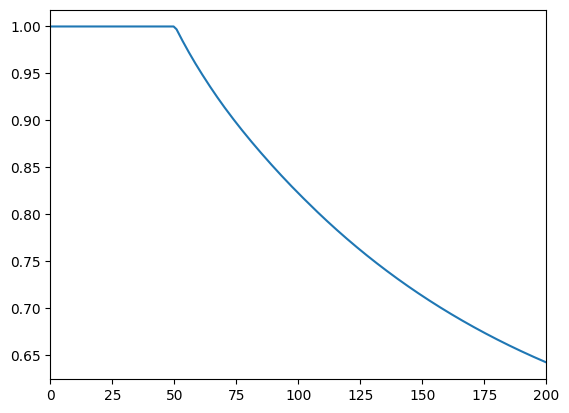

In [25]:
agent = PortfolioConsumerType(**agent_parameters)
agent.solve()

plot_funcs(agent.solution[0].ShareFuncAdj, 0, 200)

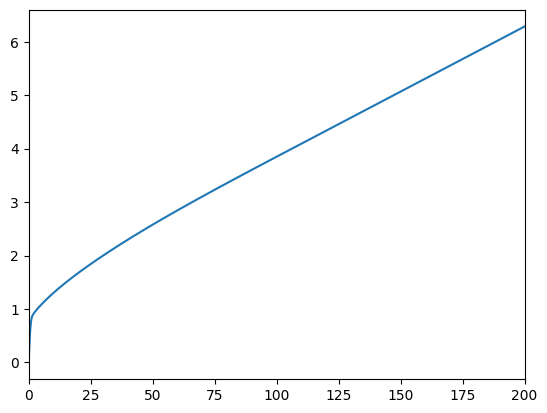

In [29]:
plot_funcs(agent.solution[0].cFuncAdj, 0, 200)